In [1]:
import gc
import glob
import os
import json
import matplotlib.pyplot as plt
import pprint

import numpy as np
import pandas as pd

from joblib import Parallel,  delayed
from tqdm import tqdm
from PIL import Image

%matplotlib inline

pd.options.display.max_rows = 128
pd.options.display.max_columns = 128

In [2]:
os.listdir('input/test/')

['sample_submission.csv', 'test.csv']

In [3]:
train = pd.read_csv('input/train/train.csv')
test = pd.read_csv('input/test/test.csv')
sample_submission = pd.read_csv('input/test/sample_submission.csv')

In [4]:
labels_breed = pd.read_csv('input/breed_labels.csv')
labels_state = pd.read_csv('input/state_labels.csv')
labels_color = pd.read_csv('input/color_labels.csv')

In [5]:
train_image_files = sorted(glob.glob('input/train_images/*.jpg'))
train_metadata_files = sorted(glob.glob('input/train_metadata/*.json'))
train_sentiment_files = sorted(glob.glob('input/train_sentiment/*.json'))

print('num of train images files: {}'.format(len(train_image_files)))
print('num of train metadata files: {}'.format(len(train_metadata_files)))
print('num of train sentiment files: {}'.format(len(train_sentiment_files)))

print("\n\n")

test_image_files = sorted(glob.glob('input/test_images/*.jpg'))
test_metadata_files = sorted(glob.glob('input/test_metadata/*.json'))
test_sentiment_files = sorted(glob.glob('input/test_sentiment/*.json'))

print('num of test images files: {}'.format(len(test_image_files)))
print('num of test metadata files: {}'.format(len(test_metadata_files)))
print('num of test sentiment files: {}'.format(len(test_sentiment_files)))


num of train images files: 58311
num of train metadata files: 58311
num of train sentiment files: 14442



num of test images files: 14465
num of test metadata files: 14465
num of test sentiment files: 3865


In [6]:
#Train Images:
train_df_ids = train[['PetID']]
print(train_df_ids.shape)

train_df_imgs = pd.DataFrame(train_image_files)
train_df_imgs.columns = ['image_filename']
#print(train_df_imgs)
train_imgs_pets = train_df_imgs['image_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
train_imgs_pets = train_imgs_pets.apply(lambda x: x.split("\\")[-1])

#print("\n\n",train_imgs_pets)
train_df_imgs = train_df_imgs.assign(PetID=train_imgs_pets)
print(len(train_imgs_pets.unique()))

pets_with_images = len(np.intersect1d(train_imgs_pets.unique(), train_df_ids['PetID'].unique()))
print('fraction of pets with images: {:.3f}'.format(pets_with_images / train_df_ids.shape[0]))



(14993, 1)
14652
fraction of pets with images: 0.977


In [7]:
#Train Metadata:

train_df_ids = train[['PetID']]
train_df_metadata = pd.DataFrame(train_metadata_files)
train_df_metadata.columns = ['metadata_filename']
train_metadata_pets = train_df_metadata['metadata_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
train_metadata_pets = train_metadata_pets.apply(lambda x: x.split("\\")[-1])
train_df_metadata = train_df_metadata = train_df_metadata.assign(PetID=train_metadata_pets)
print(len(train_metadata_pets.unique()))

pets_with_metadatas = len(np.intersect1d(train_metadata_pets.unique(), train_df_ids['PetID'].unique()))
print('fraction of pets with metadata: {:.3f}'.format(pets_with_metadatas /train_df_ids.shape[0]))


14652
fraction of pets with metadata: 0.977


In [8]:

#Train Sentiment:

train_df_ids = train[['PetID']]
train_df_sentiment = pd.DataFrame(train_sentiment_files)
train_df_sentiment.columns = ['sentiment_filename']
train_sentiment_pets = train_df_sentiment['sentiment_filename'].apply(lambda x: x.split('/')[-1].split('.')[0])
train_sentiment_pets = train_sentiment_pets.apply(lambda x: x.split("\\")[-1])
train_df_sentiment = train_df_sentiment.assign(PetID=train_sentiment_pets)
print(len(train_sentiment_pets.unique()))

pets_with_sentiments = len(np.intersect1d(train_sentiment_pets.unique(), train_df_ids['PetID'].unique()))
print('fraction of pets with sentiment: {:.3f}'.format(pets_with_sentiments/train_df_ids.shape[0]))                             

14442
fraction of pets with sentiment: 0.963


In [9]:
#Test Images
test_df_ids = test[['PetID']]
print(test_df_ids.shape)

test_df_imgs = pd.DataFrame(test_image_files)
test_df_imgs.columns = ['image_filename']
test_imgs_pets = test_df_imgs['image_filename'].apply(lambda x: x.split('/') [-1].split('-')[0])
test_imgs_pets = test_imgs_pets.apply(lambda x: x.split("\\")[-1])
test_df_imgs = test_df_imgs.assign(PetID = test_imgs_pets)
print(len(test_imgs_pets.unique()))

pets_with_images = len(np.intersect1d(test_imgs_pets.unique(), test_df_ids['PetID'].unique()))
print('fraction of pets with images: {:.3f}'.format(pets_with_images / test_df_ids.shape[0]))

(3972, 1)
3858
fraction of pets with images: 0.971


In [10]:
#Test Metadata:
test_df_ids = test[['PetID']]
test_df_metadata = pd.DataFrame(test_metadata_files)
test_df_metadata.columns = ['metadata_filename']
test_metadata_pets = test_df_metadata['metadata_filename'].apply(lambda x: x.split('/')[-1].split ('-') [0])
test_metadata_pets = test_metadata_pets.apply(lambda x: x.split("\\")[-1])
test_df_metadata = test_df_metadata.assign(PetID=test_metadata_pets)
print(len(test_metadata_pets.unique()))

pets_with_metadatas = len(np.intersect1d(test_metadata_pets.unique(), test_df_ids ['PetID'].unique ()))
print('fraction of pets with metadata: {:.3f}'.format(pets_with_metadatas / test_df_ids.shape[0]))

3858
fraction of pets with metadata: 0.971


In [11]:
#Test Sentiment:
test_df_ids = test[['PetID']]
test_df_sentiment = pd.DataFrame(test_sentiment_files)
test_df_sentiment.columns = ['sentiment_filename']
test_sentiment_pets = test_df_sentiment['sentiment_filename'].apply(lambda x: x.split('/')[-1].split('.')[0])
test_sentiment_pets = test_sentiment_pets.apply(lambda x: x.split("\\")[-1])
test_df_sentiment = test_df_sentiment.assign(PetID=test_sentiment_pets)
print(len(test_sentiment_pets.unique()))

pets_with_sentiments = len(np.intersect1d(test_sentiment_pets.unique(), test_df_ids['PetID'].unique()))
print('fraction of pets with sentiment: {:.3f}'.format(pets_with_sentiments / test_df_ids.shape[0]))


3865
fraction of pets with sentiment: 0.973


In [12]:
#are distributions the same ?
print('images and metadata distributions the same? {}'.format(np.all(test_metadata_pets == test_imgs_pets)))

images and metadata distributions the same? True


In [13]:
class PetFinderParser(object):
    
    def __init__(self, debug=False):
        
        self.debug = debug
        self.sentence_sep = ' '
        
        # Does not have to be extracted because main DF already contains description
        self.extract_sentiment_text = True
        
    def open_metadata_file(self, filename):
        """
        Load metadata file.
        """
        with open(filename, 'r',encoding='utf8') as f:
            metadata_file = json.load(f)
        return metadata_file
            
    def open_sentiment_file(self, filename):
        """
        Load sentiment file.
        """
        with open(filename, 'r',encoding='utf8') as f:
            sentiment_file = json.load(f)
            #print(sentiment_file)
        return sentiment_file
            
    def open_image_file(self, filename):
        """
        Load image file.
        """
        image = np.asarray(Image.open(filename))
        return image
        
    def parse_sentiment_file(self, file):
        """
        Parse sentiment file. Output DF with sentiment features.
        """
        
        file_sentiment = file['documentSentiment']
        file_entities = [x['name'] for x in file['entities']]
        file_entities = self.sentence_sep.join(file_entities)

        if self.extract_sentiment_text:
            file_sentences_text = [x['text']['content'] for x in file['sentences']]
            file_sentences_text = self.sentence_sep.join(file_sentences_text)
        file_sentences_sentiment = [x['sentiment'] for x in file['sentences']]
        
        file_sentences_sentiment = pd.DataFrame.from_dict(
            file_sentences_sentiment, orient='columns').sum()
        file_sentences_sentiment = file_sentences_sentiment.add_prefix('document_').to_dict()
        
        file_sentiment.update(file_sentences_sentiment)
        
        df_sentiment = pd.DataFrame.from_dict(file_sentiment, orient='index').T
        if self.extract_sentiment_text:
            df_sentiment['text'] = file_sentences_text
            
        df_sentiment['entities'] = file_entities
        df_sentiment = df_sentiment.add_prefix('sentiment_')
        
        return df_sentiment
    
    def parse_metadata_file(self, file):
        """
        Parse metadata file. Output DF with metadata features.
        """
        
        file_keys = list(file.keys())
        
        if 'labelAnnotations' in file_keys:
            #file_annots = file['labelAnnotations'][:int(len(file['labelAnnotations']) * 0.5)]
            file_annots = file['labelAnnotations'][:]
            file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
            file_top_desc = [x['description'] for x in file_annots]
        else:
            file_top_score = np.nan
            file_top_desc = ['']
        
        file_colors = file['imagePropertiesAnnotation']['dominantColors']['colors']
        file_crops = file['cropHintsAnnotation']['cropHints']

        file_color_score = np.asarray([x['score'] for x in file_colors]).mean()
        file_color_pixelfrac = np.asarray([x['pixelFraction'] for x in file_colors]).mean()

        file_crop_conf = np.asarray([x['confidence'] for x in file_crops]).mean()
        
        if 'importanceFraction' in file_crops[0].keys():
            file_crop_importance = np.asarray([x['importanceFraction'] for x in file_crops]).mean()
        else:
            file_crop_importance = np.nan

        df_metadata = {
            'annots_score': file_top_score,
            'color_score': file_color_score,
            'color_pixelfrac': file_color_pixelfrac,
            'crop_conf': file_crop_conf,
            'crop_importance': file_crop_importance,
            'annots_top_desc': self.sentence_sep.join(file_top_desc)
        }
        
        df_metadata = pd.DataFrame.from_dict(df_metadata, orient='index').T
        df_metadata = df_metadata.add_prefix('metadata_')
        
        return df_metadata

pet_parser = PetFinderParser()


In [14]:
# Helper function for parallel data processing:
def extract_additional_features(pet_id, mode='train'):
    
    sentiment_filename = 'input/{}_sentiment/{}.json'.format(mode, pet_id)
    #print(sentiment_filename)
    #print("st")
    try:
        #print("in")
        sentiment_file = pet_parser.open_sentiment_file(sentiment_filename)
        #print("hello  ",sentiment_file)
        df_sentiment = pet_parser.parse_sentiment_file(sentiment_file)
        #print("uu  ",df_sentiment)
        df_sentiment['PetID'] = pet_id
    except FileNotFoundError:
        df_sentiment = []
    #print("art")

    dfs_metadata = []
    metadata_filenames = sorted(glob.glob('input/{}_metadata/{}*.json'.format(mode, pet_id)))
    if len(metadata_filenames) > 0:
        for f in metadata_filenames:
            metadata_file = pet_parser.open_metadata_file(f)
            df_metadata = pet_parser.parse_metadata_file(metadata_file)
            df_metadata['PetID'] = pet_id
            dfs_metadata.append(df_metadata)
        dfs_metadata = pd.concat(dfs_metadata, ignore_index=True, sort=False)
    dfs = [df_sentiment, dfs_metadata]
    #print(dfs)
    
    return dfs

In [15]:
extract_additional_features('a83d95ead',mode='train')

[   sentiment_magnitude  sentiment_score  sentiment_document_magnitude  \
 0                  0.9              0.9                           0.9   
 
    sentiment_document_score  \
 0                       0.9   
 
                                       sentiment_text sentiment_entities  \
 0  Fili just loves laying around and also loves b...           Fili sun   
 
        PetID  
 0  a83d95ead  ,
   metadata_annots_score metadata_color_score metadata_color_pixelfrac  \
 0              0.805343             0.073463                 0.014032   
 
   metadata_crop_conf metadata_crop_importance  \
 0                0.8                     0.98   
 
                             metadata_annots_top_desc      PetID  
 0  dog dog like mammal puppy dog breed dog breed ...  a83d95ead  ]

In [16]:
def pet_parsing(train, test):
    
    # Unique IDs from train and test:
    debug = False
    train_pet_ids = train.PetID.unique()
    test_pet_ids = test.PetID.unique()

    if debug:
        train_pet_ids = train_pet_ids[:10]
        test_pet_ids = test_pet_ids[:5]

    # Train set:
    # Parallel processing of data:
    dfs_train = Parallel(n_jobs=6, verbose=1)(
        delayed(extract_additional_features)(i, mode='train') for i in train_pet_ids)

    # Extract processed data and format them as DFs:
    train_dfs_sentiment = [x[0] for x in dfs_train if isinstance(x[0], pd.DataFrame)]
    print(train_dfs_sentiment)
    train_dfs_metadata = [x[1] for x in dfs_train if isinstance(x[1], pd.DataFrame)]
    print(train_dfs_metadata)

    train_dfs_sentiment = pd.concat(train_dfs_sentiment, ignore_index=True, sort=False)
    train_dfs_metadata = pd.concat(train_dfs_metadata, ignore_index=True, sort=False)

    print(train_dfs_sentiment.shape, train_dfs_metadata.shape)

    # Test set:
    # Parallel processing of data:
    dfs_test = Parallel(n_jobs=6, verbose=1)(
        delayed(extract_additional_features)(i, mode='test') for i in test_pet_ids)

    # Extract processed data and format them as DFs:
    test_dfs_sentiment = [x[0] for x in dfs_test if isinstance(x[0], pd.DataFrame)]
    test_dfs_metadata = [x[1] for x in dfs_test if isinstance(x[1], pd.DataFrame)]

    test_dfs_sentiment = pd.concat(test_dfs_sentiment, ignore_index=True, sort=False)
    test_dfs_metadata = pd.concat(test_dfs_metadata, ignore_index=True, sort=False)

    print(test_dfs_sentiment.shape, test_dfs_metadata.shape)
    return train_dfs_sentiment,train_dfs_metadata,test_dfs_sentiment,test_dfs_metadata


train_dfs_sentiment, train_dfs_metadata, test_dfs_sentiment, test_dfs_metadata = pet_parsing(train,test)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   17.5s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   38.8s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed: 17.5mi

(14442, 7) (58311, 7)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed:   11.8s
[Parallel(n_jobs=6)]: Done 864 tasks      | elapsed:   30.4s
[Parallel(n_jobs=6)]: Done 1564 tasks      | elapsed:   54.3s
[Parallel(n_jobs=6)]: Done 2464 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 3564 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 3972 out of 3972 | elapsed:  2.3min finished


(3865, 7) (14465, 7)


In [17]:
train = train.merge(train_dfs_sentiment[['sentiment_text', 'PetID']], how='left', on='PetID')
test = test.merge(test_dfs_sentiment[['sentiment_text', 'PetID']], how='left', on='PetID')

train['sentiment_text'] = train['sentiment_text'].apply(lambda x: str(x).replace('.', ' '))
train['sentiment_text'] = train['sentiment_text'].apply(lambda x: str(x).replace(',', ' '))

test['sentiment_text'] = test['sentiment_text'].apply(lambda x: str(x).replace('.', ' '))
test['sentiment_text'] = test['sentiment_text'].apply(lambda x: str(x).replace(',', ' '))

# at this moment, just drop 
train_dfs_sentiment = train_dfs_sentiment.drop(['sentiment_text'], axis=1)
test_dfs_sentiment = test_dfs_sentiment.drop(['sentiment_text'], axis=1)

In [18]:
# Extend aggregates and improve column naming
aggregates = ['mean', 'sum', 'median', 'min', 'max']

# Train
train_metadata_desc = train_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
train_metadata_desc = train_metadata_desc.reset_index()
train_metadata_desc[
    'metadata_annots_top_desc'] = train_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
train_metadata_gr = train_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in train_metadata_gr.columns:
    if 'PetID' not in i:
        train_metadata_gr[i] = train_metadata_gr[i].astype(float)
train_metadata_gr = train_metadata_gr.groupby(['PetID']).agg(aggregates)
train_metadata_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in train_metadata_gr.columns.tolist()])
train_metadata_gr = train_metadata_gr.reset_index()


train_sentiment_desc = train_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
train_sentiment_desc = train_sentiment_desc.reset_index()
train_sentiment_desc[
    'sentiment_entities'] = train_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
train_sentiment_gr = train_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in train_sentiment_gr.columns:
    if 'PetID' not in i:
        train_sentiment_gr[i] = train_sentiment_gr[i].astype(float)
train_sentiment_gr = train_sentiment_gr.groupby(['PetID']).agg(aggregates)
train_sentiment_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in train_sentiment_gr.columns.tolist()])
train_sentiment_gr = train_sentiment_gr.reset_index()


# Test
test_metadata_desc = test_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
test_metadata_desc = test_metadata_desc.reset_index()
test_metadata_desc[
    'metadata_annots_top_desc'] = test_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
test_metadata_gr = test_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in test_metadata_gr.columns:
    if 'PetID' not in i:
        test_metadata_gr[i] = test_metadata_gr[i].astype(float)
test_metadata_gr = test_metadata_gr.groupby(['PetID']).agg(aggregates)
test_metadata_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in test_metadata_gr.columns.tolist()])
test_metadata_gr = test_metadata_gr.reset_index()


test_sentiment_desc = test_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
test_sentiment_desc = test_sentiment_desc.reset_index()
test_sentiment_desc[
    'sentiment_entities'] = test_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
test_sentiment_gr = test_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in test_sentiment_gr.columns:
    if 'PetID' not in i:
        test_sentiment_gr[i] = test_sentiment_gr[i].astype(float)
test_sentiment_gr = test_sentiment_gr.groupby(['PetID']).agg(aggregates)
test_sentiment_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in test_sentiment_gr.columns.tolist()])
test_sentiment_gr = test_sentiment_gr.reset_index()

In [19]:
# Train merges:
train_proc = train.copy()
train_proc = train_proc.merge(
    train_sentiment_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_desc, how='left', on='PetID')
train_proc = train_proc.merge(
    train_sentiment_desc, how='left', on='PetID')

# Test merges:
test_proc = test.copy()
test_proc = test_proc.merge(
    test_sentiment_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_desc, how='left', on='PetID')
test_proc = test_proc.merge(
    test_sentiment_desc, how='left', on='PetID')

print("Train shape {}, test shape {} after adding sentiment and metadata features".format(train_proc.shape, test_proc.shape))
assert train_proc.shape[0] == train.shape[0]
assert test_proc.shape[0] == test.shape[0]


Train shape (14993, 72), test shape (3972, 71) after adding sentiment and metadata features


In [20]:
#ADDING BREED FEATURES


train_breed_main = train_proc[['Breed1']].merge(
    labels_breed, how='left',
    left_on='Breed1', right_on='BreedID',
    suffixes=('', '_main_breed'))

train_breed_main = train_breed_main.iloc[:, 2:]
train_breed_main = train_breed_main.add_prefix('main_breed_')

train_breed_second = train_proc[['Breed2']].merge(
    labels_breed, how='left',
    left_on='Breed2', right_on='BreedID',
    suffixes=('', '_second_breed'))

train_breed_second = train_breed_second.iloc[:, 2:]
train_breed_second = train_breed_second.add_prefix('second_breed_')


train_proc = pd.concat(
    [train_proc, train_breed_main, train_breed_second], axis=1)


test_breed_main = test_proc[['Breed1']].merge(
    labels_breed, how='left',
    left_on='Breed1', right_on='BreedID',
    suffixes=('', '_main_breed'))

test_breed_main = test_breed_main.iloc[:, 2:]
test_breed_main = test_breed_main.add_prefix('main_breed_')

test_breed_second = test_proc[['Breed2']].merge(
    labels_breed, how='left',
    left_on='Breed2', right_on='BreedID',
    suffixes=('', '_second_breed'))

test_breed_second = test_breed_second.iloc[:, 2:]
test_breed_second = test_breed_second.add_prefix('second_breed_')

test_proc = pd.concat(
    [test_proc, test_breed_main, test_breed_second], axis=1)

print("Train shape {}, test shape {} after adding breed features".format(train_proc.shape, test_proc.shape))

Train shape (14993, 76), test shape (3972, 75) after adding breed features


In [21]:
X = pd.concat([train_proc, test_proc], ignore_index=True, sort=False)
print('NaN Structure:\n{}'.format(np.sum(pd.isnull(X))))

NaN Structure:
Type                                                 0
Name                                              1668
Age                                                  0
Breed1                                               0
Breed2                                               0
Gender                                               0
Color1                                               0
Color2                                               0
Color3                                               0
MaturitySize                                         0
FurLength                                            0
Vaccinated                                           0
Dewormed                                             0
Sterilized                                           0
Health                                               0
Quantity                                             0
Fee                                                  0
State                                             

In [22]:
column_types = X.dtypes

int_cols = column_types[column_types == 'int']
float_cols = column_types[column_types == 'float']
cat_cols = column_types[column_types == 'object']

print('\tinteger columns:\n{}'.format(int_cols))
print('\n\tfloat columns:\n{}'.format(float_cols))
print('\n\tto encode categorical columns:\n{}'.format(cat_cols))

	integer columns:
Series([], dtype: object)

	float columns:
PhotoAmt                                         float64
AdoptionSpeed                                    float64
sentiment_sentiment_magnitude_MEAN               float64
sentiment_sentiment_magnitude_SUM                float64
sentiment_sentiment_magnitude_MEDIAN             float64
sentiment_sentiment_magnitude_MIN                float64
sentiment_sentiment_magnitude_MAX                float64
sentiment_sentiment_score_MEAN                   float64
sentiment_sentiment_score_SUM                    float64
sentiment_sentiment_score_MEDIAN                 float64
sentiment_sentiment_score_MIN                    float64
sentiment_sentiment_score_MAX                    float64
sentiment_sentiment_document_magnitude_MEAN      float64
sentiment_sentiment_document_magnitude_SUM       float64
sentiment_sentiment_document_magnitude_MEDIAN    float64
sentiment_sentiment_document_magnitude_MIN       float64
sentiment_sentiment_documen

In [23]:
# Copy original X DF for easier experimentation,
# all feature engineering will be performed on this one: 
X_temp = X.copy()
# Select subsets of columns: 
text_columns = ['Description', 'metadata_annots_top_desc', 'sentiment_entities','sentiment_text']
categorical_columns = ['main_breed_BreedName', 'second_breed_BreedName']
# Names are all unique, so they can be dropped by default
# Same goes for PetID, it shouldn't be used as a feature
to_drop_columns = ['PetID', 'Name', 'RescuerID']
# RescuerID will also be dropped, as a feature based on this column will be extracted independently


In [24]:
# Count RescuerID occurrences:

rescuer_count = X.groupby(['RescuerID'])['PetID'].count().reset_index() 
rescuer_count.columns = ['RescuerID', 'RescuerID_COUNT']

# Merge as another feature onto main DF: 
X_temp = X_temp.merge(rescuer_count, how='left', on='RescuerID')


# Factorize categorical columns:
for i in categorical_columns:
    X_temp.loc[: , i] = pd.factorize(X_temp.loc[:, i])[0]


# Subset text features: 
X_text = X_temp[text_columns]

for i in X_text.columns:
    X_text.loc[:, i] = X_text.loc[:, i].fillna('<MISSING>')

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import SparsePCA, TruncatedSVD, LatentDirichletAllocation, NMF

n_components = 5
text_features = []

# Generate text features: 
for i in X_text.columns:

    # Initialize decomposition methods:
    print('generating features from: {}'.format(i))
    svd_ = TruncatedSVD(
    n_components=n_components, random_state=1337)
    nmf_ = NMF(
    n_components=n_components, random_state=1337)

    tfidf_col = TfidfVectorizer().fit_transform(X_text.loc[:, i].values)
    svd_col = svd_.fit_transform(tfidf_col)
    svd_col = pd.DataFrame(svd_col)
    svd_col = svd_col.add_prefix('SVD_{}'.format(i))

    nmf_col = nmf_.fit_transform(tfidf_col)
    nmf_col = pd.DataFrame(nmf_col)
    nmf_col = nmf_col.add_prefix('NMF_{}_'.format(i))
    text_features.append(svd_col) 
    text_features.append(nmf_col)

# Combine all extracted features:
text_features = pd.concat(text_features, axis=1)
# Concatenate with main DF:
X_temp = pd.concat([X_temp, text_features], axis=1)

#Remove raw text columns:
for i in X_text.columns:
    X_temp = X_temp.drop(i, axis=1)


generating features from: Description


c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


generating features from: metadata_annots_top_desc


c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


generating features from: sentiment_entities


c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


generating features from: sentiment_text


c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [26]:
# Remove unnecessary columns:
X_temp = X_temp.drop(to_drop_columns, axis=1)
# Check final df shape:
print('X shape: {}'.format(X_temp.shape))


X shape: (18965, 110)


In [27]:
# Split into train and test again:
X_train = X_temp.loc[np.isfinite(X_temp.AdoptionSpeed), :] 
X_test = X_temp.loc[~np.isfinite(X_temp.AdoptionSpeed), :]

# Remove missing target column from test: 
ttest=X_test['AdoptionSpeed']
X_test = X_test.drop('AdoptionSpeed', axis=1)


print('X_train shape: {}'.format(X_train.shape)) 
print('X_test shape: {}'.format(X_test.shape))

assert X_train.shape[0] == train.shape[0]
assert X_test.shape[0] == test.shape[0]


# Check if columns between the two DFs are the same: 
train_cols = X_train.columns.tolist()
ttrain=X_train['AdoptionSpeed']
train_cols.remove('AdoptionSpeed')

test_cols = X_test.columns.tolist() 

assert np.all(train_cols == test_cols)




X_train shape: (14993, 110)
X_test shape: (3972, 109)


In [28]:
import scipy as sp
from collections import Counter
from functools import partial


from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error 
from sklearn.metrics import confusion_matrix as sk_cmatrix


def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None): 
    """
       Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b)) 
    if min_rating is None:
        min_rating = min(rater_a + rater_b) 
    if max_rating is None:
        max_rating = max(rater_a + rater_b) 
    num_ratings = int(max_rating - min_rating + 1) 
    conf_mat = [[0 for i in range(num_ratings)]
                for J in range(num_ratings)] 
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat

def histogram(ratings, min_rating=None, max_rating=None): 
    """
       Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1) 
    hist_ratings = [0 for x in range(num_ratings)] 
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

In [29]:
def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
   
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [30]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def predict_new(self, X, coef):
        X_p = np.copy(X)
        X_s = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
            X_s[i] = pred
        return X_p, X_s
        
    def coefficients(self):
        return self.coef_['x']
    
def rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# XGBoost

In [31]:
import xgboost as xgb
params = {'objective': 'reg:squarederror',
     'booster': 'gbtree',
     'eval_metric': 'rmse', 
     'max_depth': 9,  
     'min_child_weight': 0.02,
     'verbosity': 1, 
}

# Additional parameters:
early_stop = 500
verbose_eval = 100
num_rounds = 10000
n_splits = 5


In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

kfold = StratifiedKFold(n_splits=n_splits, random_state=1337,shuffle=True)

oof_train = np.zeros((X_train.shape[0])) 
oof_test = np.zeros((X_test.shape[0], n_splits))



In [33]:
i = 0
for train_index, valid_index in kfold.split(X_train, X_train['AdoptionSpeed'].values):
    X_tr = X_train.iloc[train_index, :] 
    X_val = X_train.iloc[valid_index, :]

    y_tr = X_tr['AdoptionSpeed'].values
    X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)

    y_val = X_val['AdoptionSpeed'].values
    X_val = X_val.drop(['AdoptionSpeed'], axis=1)

    print('\ny_tr distribution: {}'.format(Counter(y_tr)))

    
    d_train = xgb.DMatrix(X_tr, label=y_tr) 
    d_valid = xgb.DMatrix(X_val, label=y_val )
    
    eval_sets = [(d_valid,'test'),(d_train,'train')]
    

    print('training XGB:')
    model = xgb.train(params,
                      d_train,
                      num_boost_round=num_rounds,
                      evals=eval_sets,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    k=xgb.DMatrix(X_val)
    m=xgb.DMatrix(X_test)
    val_pred = model.predict(k)
    test_pred = model.predict(m)

    oof_train[valid_index] = val_pred 
    oof_test[:, i] = test_pred

    i += 1




y_tr distribution: Counter({4.0: 3358, 2.0: 3229, 3.0: 2607, 1.0: 2472, 0.0: 328})
training XGB:
[0]	test-rmse:1.82411	train-rmse:1.78024
[100]	test-rmse:1.10552	train-rmse:0.14970
[200]	test-rmse:1.10755	train-rmse:0.02936
[300]	test-rmse:1.10710	train-rmse:0.00643
[400]	test-rmse:1.10716	train-rmse:0.00168
[500]	test-rmse:1.10715	train-rmse:0.00081
[600]	test-rmse:1.10715	train-rmse:0.00081
[700]	test-rmse:1.10715	train-rmse:0.00081
[800]	test-rmse:1.10715	train-rmse:0.00081
[900]	test-rmse:1.10715	train-rmse:0.00081
[948]	test-rmse:1.10715	train-rmse:0.00081

y_tr distribution: Counter({4.0: 3357, 2.0: 3229, 3.0: 2608, 1.0: 2472, 0.0: 328})
training XGB:
[0]	test-rmse:1.81959	train-rmse:1.78151
[100]	test-rmse:1.09768	train-rmse:0.13879
[200]	test-rmse:1.09642	train-rmse:0.02887
[300]	test-rmse:1.09652	train-rmse:0.00645
[400]	test-rmse:1.09657	train-rmse:0.00162
[500]	test-rmse:1.09658	train-rmse:0.00086
[600]	test-rmse:1.09658	train-rmse:0.00086
[700]	test-rmse:1.09658	train-rmse

In [34]:
print(oof_train)

[2.08758044 2.06560159 2.9857378  ... 1.97817564 2.97988319 2.8282218 ]


(array([  13.,   70.,  580., 2181., 3972., 3924., 2777., 1202.,  267.,
           7.]),
 array([-0.16494414,  0.34871686,  0.86237786,  1.37603886,  1.88969986,
         2.40336086,  2.91702186,  3.43068286,  3.94434386,  4.45800486,
         4.97166586]),
 <BarContainer object of 10 artists>)

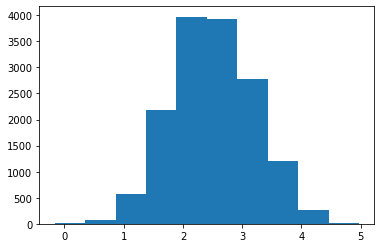

In [35]:
#Distribution of Trained Set
plt.hist(oof_train)

In [36]:
#Compute Quadratic Weighted Kappa based on OOF train predictions: 

optR = OptimizedRounder()
optR.fit(oof_train, X_train['AdoptionSpeed'].values) 
coefficients = optR.coefficients()
pred_test_y_k = optR.predict(oof_train, coefficients)
print("\nValid Counts = ", Counter(X_train['AdoptionSpeed'].values)) 
print("Predicted Counts = ", Counter(pred_test_y_k)) 
print("Coefficients = ", coefficients)
qwk = quadratic_weighted_kappa(X_train['AdoptionSpeed'].values, pred_test_y_k)
print("QWK = ", qwk)


Valid Counts =  Counter({4.0: 4197, 2.0: 4037, 3.0: 3259, 1.0: 3090, 0.0: 410})
Predicted Counts =  Counter({4.0: 3974, 2.0: 3795, 3.0: 3670, 1.0: 3535, 0.0: 19})
Coefficients =  [0.44340098 1.99379999 2.46955259 2.96246903]
QWK =  0.37227049244474153


In [37]:
#Manually adjusted coefficients: 

coefficients_ = coefficients.copy()

coefficients_[0]=1.645
coefficients_[1]=2.115
coefficients_[3]=2.84

train_predictions = optR.predict(oof_train, coefficients_).astype(int) 
print('train pred distribution: {}'.format(Counter(train_predictions)))

test_predictions = optR.predict(oof_test.mean(axis=1), coefficients_) 
print('test pred distribution: {}'.format(Counter(test_predictions)))

train pred distribution: Counter({4: 4784, 1: 2972, 3: 2860, 2: 2852, 0: 1525})
test pred distribution: Counter({4.0: 1175, 2.0: 946, 1.0: 848, 3.0: 843, 0.0: 160})


In [38]:
#Distribution inspection of original target and predicted train and test:

print("True Distribution:")
print(pd.value_counts(X_train['AdoptionSpeed'], normalize=True).sort_index())
print("\nTrain Predicted Distribution:")
print(pd.value_counts(train_predictions, normalize=True).sort_index())
print("\nTest Predicted Distribution:")
print(pd.value_counts(test_predictions, normalize=True).sort_index())

True Distribution:
0.0    0.027346
1.0    0.206096
2.0    0.269259
3.0    0.217368
4.0    0.279931
Name: AdoptionSpeed, dtype: float64

Train Predicted Distribution:
0    0.101714
1    0.198226
2    0.190222
3    0.190756
4    0.319082
dtype: float64

Test Predicted Distribution:
0.0    0.040282
1.0    0.213494
2.0    0.238167
3.0    0.212236
4.0    0.295821
dtype: float64


In [39]:
# Generate submission:

submission = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': test_predictions.astype(np.int32)})
submission.head()
submission.to_csv('submissionxgb.csv', index=False)

# XGBOOST MODEL 2

In [40]:
import xgboost as xgb
from xgboost import XGBRegressor
param_grid = {'objective': ['reg:squarederror'],
     'booster':['gbtree','gblinear','dart'],
     'eval_metric': ['rmse'], 
     'sampling_method':['gradient_based'],
     'max_depth': [10], 
     'min_child_weight': [0.02], 
     'verbosity': [1]}

n_splits = 5


In [41]:
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

kfold = StratifiedKFold(n_splits=n_splits, random_state=1337,shuffle=True)

oof_train = np.zeros((X_train.shape[0])) 
oof_test = np.zeros((X_test.shape[0], n_splits))



In [44]:
from sklearn.model_selection import GridSearchCV
i = 0
for train_index, valid_index in kfold.split(X_train, X_train['AdoptionSpeed'].values):
    X_tr = X_train.iloc[train_index, :] 
    X_val = X_train.iloc[valid_index, :]

    y_tr = X_tr['AdoptionSpeed'].values
    X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)

    y_val = X_val['AdoptionSpeed'].values
    X_val = X_val.drop(['AdoptionSpeed'], axis=1)

    print('\ny_tr distribution: {}'.format(Counter(y_tr)))

    print('training XGB:')
    grid = GridSearchCV(XGBRegressor(),param_grid,refit=True,verbose=1)
    grid.fit(X_tr,y_tr)
    grid.best_params_
    model=grid.best_estimator_
    print(model)
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)

    oof_train[valid_index] = val_pred 
    oof_test[:, i] = test_pred

    i += 1




y_tr distribution: Counter({4.0: 3358, 2.0: 3229, 3.0: 2607, 1.0: 2472, 0.0: 328})
training XGB:
Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[22:09:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_depth", "min_child_weight", "sampling_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:09:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_depth", "min_child_weight", "sampling_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:09:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_depth", "min_child_weig

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=10, min_child_weight=0.02, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             sampling_method='gradient_based', scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

y_tr distribution: Counter({4.0: 3357, 2.0: 3229, 3.0: 2608, 1.0: 2472, 0.0: 328})
training XGB:
Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[22:13:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_depth", "min_child_weight", "sampling_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:13:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_depth", "min_child_weight", "sampling_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:13:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_depth", "min_child_weig

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=10, min_child_weight=0.02, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             sampling_method='gradient_based', scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)


c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



y_tr distribution: Counter({4.0: 3357, 2.0: 3230, 3.0: 2607, 1.0: 2472, 0.0: 328})
training XGB:
Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[22:17:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_depth", "min_child_weight", "sampling_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:17:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_depth", "min_child_weight", "sampling_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:17:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_depth", "min_child_weig

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=10, min_child_weight=0.02, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             sampling_method='gradient_based', scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

y_tr distribution: Counter({4.0: 3358, 2.0: 3230, 3.0: 2607, 1.0: 2472, 0.0: 328})
training XGB:
Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[22:21:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_depth", "min_child_weight", "sampling_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:21:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_depth", "min_child_weight", "sampling_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:21:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_depth", "min_child_weig

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=10, min_child_weight=0.02, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             sampling_method='gradient_based', scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)


c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



y_tr distribution: Counter({4.0: 3358, 2.0: 3230, 3.0: 2607, 1.0: 2472, 0.0: 328})
training XGB:
Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[22:25:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_depth", "min_child_weight", "sampling_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:25:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_depth", "min_child_weight", "sampling_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:25:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_depth", "min_child_weig

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=10, min_child_weight=0.02, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             sampling_method='gradient_based', scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)


c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [45]:
print(oof_train)

[2.07934904 1.99978447 2.5976584  ... 2.09142661 3.03312278 2.20247984]


In [46]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=10, min_child_weight=0.02, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             sampling_method='gradient_based', scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

(array([  16.,   68.,  457., 1868., 3559., 3772., 3000., 1696.,  516.,
          41.]),
 array([-0.10541153,  0.3731823 ,  0.85177612,  1.33036995,  1.80896378,
         2.2875576 ,  2.76615143,  3.24474525,  3.72333908,  4.20193291,
         4.68052673]),
 <BarContainer object of 10 artists>)

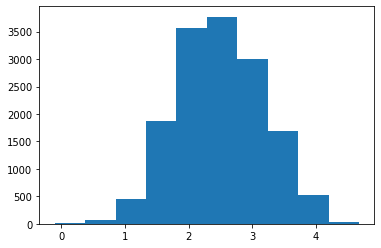

In [47]:
#Distribution of Trained Set
plt.hist(oof_train)

In [48]:
#Compute Quadratic Weighted Kappa based on OOF train predictions: 

optR = OptimizedRounder()
optR.fit(oof_train, X_train['AdoptionSpeed'].values) 
coefficients = optR.coefficients()
pred_test_y_k = optR.predict(oof_train, coefficients)
print("\nValid Counts = ", Counter(X_train['AdoptionSpeed'].values)) 
print("Predicted Counts = ", Counter(pred_test_y_k)) 
print("Coefficients = ", coefficients)
qwk = quadratic_weighted_kappa(X_train['AdoptionSpeed'].values, pred_test_y_k)
print("QWK = ", qwk)


Valid Counts =  Counter({4.0: 4197, 2.0: 4037, 3.0: 3259, 1.0: 3090, 0.0: 410})
Predicted Counts =  Counter({3.0: 4081, 2.0: 3987, 1.0: 3482, 4.0: 3426, 0.0: 17})
Coefficients =  [0.44206621 1.97283932 2.47715686 3.03132728]
QWK =  0.35923833251858006


In [49]:
#Manually adjusted coefficients: 

coefficients_ = coefficients.copy()

coefficients_[0]=1.645
coefficients_[1]=2.115
coefficients_[3]=2.84

train_predictions = optR.predict(oof_train, coefficients_).astype(int) 
print('train pred distribution: {}'.format(Counter(train_predictions)))

test_predictions = optR.predict(oof_test.mean(axis=1), coefficients_) 
print('test pred distribution: {}'.format(Counter(test_predictions)))

train pred distribution: Counter({4: 4704, 1: 3048, 2: 2874, 3: 2803, 0: 1564})
test pred distribution: Counter({4.0: 1151, 2.0: 998, 1.0: 865, 3.0: 803, 0.0: 155})


In [50]:
#Distribution inspection of original target and predicted train and test:

print("True Distribution:")
print(pd.value_counts(X_train['AdoptionSpeed'], normalize=True).sort_index())
print("\nTrain Predicted Distribution:")
print(pd.value_counts(train_predictions, normalize=True).sort_index())
print("\nTest Predicted Distribution:")
print(pd.value_counts(test_predictions, normalize=True).sort_index())

True Distribution:
0.0    0.027346
1.0    0.206096
2.0    0.269259
3.0    0.217368
4.0    0.279931
Name: AdoptionSpeed, dtype: float64

Train Predicted Distribution:
0    0.104315
1    0.203295
2    0.191689
3    0.186954
4    0.313746
dtype: float64

Test Predicted Distribution:
0.0    0.039023
1.0    0.217774
2.0    0.251259
3.0    0.202165
4.0    0.289778
dtype: float64


In [51]:
# Generate submission:

submission = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': test_predictions.astype(np.int32)})
submission.head()
submission.to_csv('submissionxgb2.csv', index=False)

# LGBM 

In [60]:
import lightgbm as lgb
params = {'application': 'regression',
     'boosting': 'gbdt',
     'metric': 'rmse', 
     'num_leaves': 70, 
     'max_depth': 9, 
     'learning_rate': 0.01, 
     'bagging_fraction': 0.85, 
     'feature_fraction': 0.8, 
     'min_split_gain': 0.02, 
     'min_child_samples': 150, 
     'min_child_weight': 0.02, 
     'lambda_12': 0.0475,
     'verbosity': -1, 
     'data_random_seed': 17}

# Additional parameters:
early_stop = 500
verbose_eval = 100
num_rounds = 10000
n_splits = 5


In [61]:
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

kfold = StratifiedKFold(n_splits=n_splits, random_state=1337,shuffle=True)

oof_train = np.zeros((X_train.shape[0])) 
oof_test = np.zeros((X_test.shape[0], n_splits))

i = 0
for train_index, valid_index in kfold.split(X_train, X_train['AdoptionSpeed'].values):
    X_tr = X_train.iloc[train_index, :] 
    X_val = X_train.iloc[valid_index, :]

    y_tr = X_tr['AdoptionSpeed'].values
    X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)

    y_val = X_val['AdoptionSpeed'].values
    X_val = X_val.drop(['AdoptionSpeed'], axis=1)

    print('\ny_tr distribution: {}'.format(Counter(y_tr)))

    d_train = lgb.Dataset(X_tr, label=y_tr) 
    d_valid = lgb.Dataset(X_val, label=y_val) 
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    test_pred = model.predict(X_test, num_iteration=model.best_iteration)

    oof_train[valid_index] = val_pred 
    oof_test[:, i] = test_pred

    i += 1




y_tr distribution: Counter({4.0: 3358, 2.0: 3229, 3.0: 2607, 1.0: 2472, 0.0: 328})
training LGB:
[LightGBM] [Warning] Unknown parameter: lambda_12
Training until validation scores don't improve for 500 rounds
[100]	training's rmse: 1.05737	valid_1's rmse: 1.09081
[200]	training's rmse: 1.00329	valid_1's rmse: 1.06554
[300]	training's rmse: 0.966466	valid_1's rmse: 1.05525
[400]	training's rmse: 0.937936	valid_1's rmse: 1.04999
[500]	training's rmse: 0.916219	valid_1's rmse: 1.04703
[600]	training's rmse: 0.898507	valid_1's rmse: 1.04463
[700]	training's rmse: 0.883164	valid_1's rmse: 1.04327
[800]	training's rmse: 0.869297	valid_1's rmse: 1.04235
[900]	training's rmse: 0.857224	valid_1's rmse: 1.04184
[1000]	training's rmse: 0.844705	valid_1's rmse: 1.04177
[1100]	training's rmse: 0.829924	valid_1's rmse: 1.04203
[1200]	training's rmse: 0.818743	valid_1's rmse: 1.04242
[1300]	training's rmse: 0.80683	valid_1's rmse: 1.04244
[1400]	training's rmse: 0.794375	valid_1's rmse: 1.04283
Earl

In [62]:
print(oof_train)

[2.32344014 2.54626238 2.15597887 ... 2.31061592 2.84150675 2.50648463]


(array([  19.,  192., 1112., 2608., 3378., 3130., 2342., 1506.,  594.,
         112.]),
 array([0.81659746, 1.14634014, 1.47608282, 1.8058255 , 2.13556818,
        2.46531086, 2.79505354, 3.12479622, 3.4545389 , 3.78428158,
        4.11402426]),
 <BarContainer object of 10 artists>)

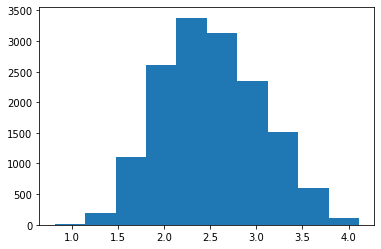

In [63]:
#Distribution of Trained Set
plt.hist(oof_train)

In [64]:
#Compute Quadratic Weighted Kappa based on OOF train predictions: 

optR = OptimizedRounder()
optR.fit(oof_train, X_train['AdoptionSpeed'].values) 
coefficients = optR.coefficients()
pred_test_y_k = optR.predict(oof_train, coefficients)
print("\nValid Counts = ", Counter(X_train['AdoptionSpeed'].values)) 
print("Predicted Counts = ", Counter(pred_test_y_k)) 
print("Coefficients = ", coefficients)
qwk = quadratic_weighted_kappa(X_train['AdoptionSpeed'].values, pred_test_y_k)
print("QWK = ", qwk)


Valid Counts =  Counter({4.0: 4197, 2.0: 4037, 3.0: 3259, 1.0: 3090, 0.0: 410})
Predicted Counts =  Counter({1.0: 4006, 2.0: 3952, 4.0: 3691, 3.0: 3344})
Coefficients =  [0.4706801  2.14387893 2.52796109 2.9045697 ]
QWK =  0.44753487274504933


In [65]:
#Manually adjusted coefficients: 

coefficients_ = coefficients.copy()

coefficients_[0]=1.645
coefficients_[1]=2.115
coefficients_[3]=2.84

train_predictions = optR.predict(oof_train, coefficients_).astype(int) 
print('train pred distribution: {}'.format(Counter(train_predictions)))

test_predictions = optR.predict(oof_test.mean(axis=1), coefficients_) 
print('test pred distribution: {}'.format(Counter(test_predictions)))

train pred distribution: Counter({2: 4229, 4: 4172, 1: 3143, 3: 2863, 0: 586})
test pred distribution: Counter({4.0: 1245, 2.0: 1096, 1.0: 807, 3.0: 730, 0.0: 94})


In [66]:
#Distribution inspection of original target and predicted train and test:

print("True Distribution:")
print(pd.value_counts(X_train['AdoptionSpeed'], normalize=True).sort_index())
print("\nTrain Predicted Distribution:")
print(pd.value_counts(train_predictions, normalize=True).sort_index())
print("\nTest Predicted Distribution:")
print(pd.value_counts(test_predictions, normalize=True).sort_index())

True Distribution:
0.0    0.027346
1.0    0.206096
2.0    0.269259
3.0    0.217368
4.0    0.279931
Name: AdoptionSpeed, dtype: float64

Train Predicted Distribution:
0    0.039085
1    0.209631
2    0.282065
3    0.190956
4    0.278263
dtype: float64

Test Predicted Distribution:
0.0    0.023666
1.0    0.203172
2.0    0.275932
3.0    0.183787
4.0    0.313444
dtype: float64


In [67]:
# Generate submission:

submission = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': test_predictions.astype(np.int32)})
submission.head()
submission.to_csv('submissionlight.csv', index=False)

# LGBM MODEL 2

In [68]:
import lightgbm as lgb
params = {'application': ['regression'],
     'boosting': ['gbdt','rf','dart','goss'],
     'metric': ['rmse','mae'], 
     'num_leaves': [70,80], 
     'max_depth': [10,15], 
     'learning_rate': [0.01,0.1], 
     'bagging_fraction': [0.85], 
     'feature_fraction': [0.8], 
     'min_split_gain': [0.02], 
     'min_child_samples': [150], 
     'min_child_weight': [0.02], 
     'verbosity': [-1], 
     'data_random_seed': [17]}


# Additional parameters:

verbose_eval = 100
num_rounds = 10000
n_splits = 5


In [69]:
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

kfold = StratifiedKFold(n_splits=n_splits, random_state=1337,shuffle=True)

oof_train = np.zeros((X_train.shape[0])) 
oof_test = np.zeros((X_test.shape[0], n_splits))

i = 0
for train_index, valid_index in kfold.split(X_train, X_train['AdoptionSpeed'].values):
    X_tr = X_train.iloc[train_index, :] 
    X_val = X_train.iloc[valid_index, :]

    y_tr = X_tr['AdoptionSpeed'].values
    X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)

    y_val = X_val['AdoptionSpeed'].values
    X_val = X_val.drop(['AdoptionSpeed'], axis=1)

    print('\ny_tr distribution: {}'.format(Counter(y_tr)))

    d_train = lgb.Dataset(X_tr, label=y_tr) 
    d_valid = lgb.Dataset(X_val, label=y_val) 
    watchlist = [d_train, d_valid]

    print('training LGB:')
    grid = GridSearchCV(lgb.LGBMRegressor(),params,refit=True,verbose=1)
    grid.fit(X_tr,y_tr)
    grid.best_params_
    model=grid.best_estimator_
    
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)
   
    oof_train[valid_index] = val_pred 
    oof_test[:, i] = test_pred

    i += 1




y_tr distribution: Counter({4.0: 3358, 2.0: 3229, 3.0: 2607, 1.0: 2472, 0.0: 328})
training LGB:
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_f

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [ 0.13405454  0.13405454  0.13405454  0.13405454  0.13400515  0.13400515
  0.13400515  0.13400515  0.19873398  0.19873398  0.19873398  0.19873398
  0.19588341  0.19588341  0.19588341  0.19588341         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan -0.56313813 -0.56313813 -0.56313813 -0.56313813
 -0.5630227  -0.5630227  -0.5630227  -0.5630227   0.14263822  0.14263822
  0.14263822  0.14263822  0.14305144  0.14305144  0.14305144  0.14305144
  0.13405454  0.13405454  0.13405454  0.13405454  0.13400515  0.13400515
  0.13400515  0.13400515  0.17077918  0.17077918  0.17077918  0.17077918
  0.17200987  0.17200987  0.17200987  0.17200987]
  warnings.warn(


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85

y_tr distribution: Counter({4.0: 3357, 2.0: 3229, 3.0: 2608, 1.0: 2472, 0.0: 328})
training LGB:
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_f

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [ 0.13413834  0.13413834  0.13413834  0.13413834  0.13414642  0.13414642
  0.13414642  0.13414642  0.19077205  0.19077205  0.19077205  0.19077205
  0.19327219  0.19327219  0.19327219  0.19327219         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan -0.56312844 -0.56312844 -0.56312844 -0.56312844
 -0.56313709 -0.56313709 -0.56313709 -0.56313709  0.13825116  0.13825116
  0.13825116  0.13825116  0.13780245  0.13780245  0.13780245  0.13780245
  0.13413834  0.13413834  0.13413834  0.13413834  0.13414642  0.13414642
  0.13414642  0.13414642  0.16772346  0.16772346  0.16772346  0.16772346
  0.16716796  0.16716796  0.16716796  0.16716796]
  warnings.warn(


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85

y_tr distribution: Counter({4.0: 3357, 2.0: 3230, 3.0: 2607, 1.0: 2472, 0.0: 328})
training LGB:
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_f

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [ 0.13841901  0.13841901  0.13841901  0.13841901  0.13843003  0.13843003
  0.13843003  0.13843003  0.20099761  0.20099761  0.20099761  0.20099761
  0.20125175  0.20125175  0.20125175  0.20125175         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan -0.55941049 -0.55941049 -0.55941049 -0.55941049
 -0.55936106 -0.55936106 -0.55936106 -0.55936106  0.14563541  0.14563541
  0.14563541  0.14563541  0.14637351  0.14637351  0.14637351  0.14637351
  0.13841901  0.13841901  0.13841901  0.13841901  0.13843003  0.13843003
  0.13843003  0.13843003  0.17658299  0.17658299  0.17658299  0.17658299
  0.1779189   0.1779189   0.1779189   0.1779189 ]
  warnings.warn(


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85

y_tr distribution: Counter({4.0: 3358, 2.0: 3230, 3.0: 2607, 1.0: 2472, 0.0: 328})
training LGB:
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_f

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [ 0.13782996  0.13782996  0.13782996  0.13782996  0.13791485  0.13791485
  0.13791485  0.13791485  0.20157412  0.20157412  0.20157412  0.20157412
  0.20174621  0.20174621  0.20174621  0.20174621         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan -0.56004233 -0.56004233 -0.56004233 -0.56004233
 -0.56016123 -0.56016123 -0.56016123 -0.56016123  0.14743541  0.14743541
  0.14743541  0.14743541  0.14870968  0.14870968  0.14870968  0.14870968
  0.13782996  0.13782996  0.13782996  0.13782996  0.13791485  0.13791485
  0.13791485  0.13791485  0.1816528   0.1816528   0.1816528   0.1816528
  0.17742365  0.17742365  0.17742365  0.17742365]
  warnings.warn(


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85

y_tr distribution: Counter({4.0: 3358, 2.0: 3230, 3.0: 2607, 1.0: 2472, 0.0: 328})
training LGB:
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_f

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=t

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 w

c:\users\teja\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [ 0.13417109  0.13417109  0.13417109  0.13417109  0.13429315  0.13429315
  0.13429315  0.13429315  0.19722174  0.19722174  0.19722174  0.19722174
  0.19568617  0.19568617  0.19568617  0.19568617         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan -0.56254462 -0.56254462 -0.56254462 -0.56254462
 -0.56277236 -0.56277236 -0.56277236 -0.56277236  0.14242715  0.14242715
  0.14242715  0.14242715  0.14300194  0.14300194  0.14300194  0.14300194
  0.13417109  0.13417109  0.13417109  0.13417109  0.13429315  0.13429315
  0.13429315  0.13429315  0.16524517  0.16524517  0.16524517  0.16524517
  0.168054    0.168054    0.168054    0.168054  ]
  warnings.warn(


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85


In [70]:
grid.best_estimator_

LGBMRegressor(application='regression', bagging_fraction=0.85, boosting='gbdt',
              data_random_seed=17, feature_fraction=0.8, max_depth=10,
              metric='rmse', min_child_samples=150, min_child_weight=0.02,
              min_split_gain=0.02, num_leaves=70, verbosity=-1)

In [71]:
print(oof_train)

[2.20895679 2.57513073 1.99685137 ... 2.27228734 2.69960874 2.54728312]


(array([  27.,  253., 1229., 2799., 3500., 3153., 2227., 1322.,  428.,
          55.]),
 array([0.77278378, 1.12175206, 1.47072034, 1.81968862, 2.16865689,
        2.51762517, 2.86659345, 3.21556173, 3.56453   , 3.91349828,
        4.26246656]),
 <BarContainer object of 10 artists>)

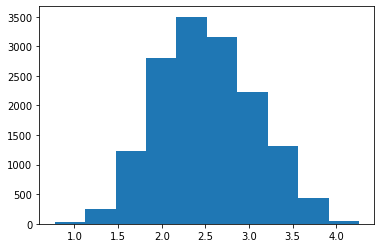

In [72]:
#Distribution of Trained Set
plt.hist(oof_train)

In [73]:
#Compute Quadratic Weighted Kappa based on OOF train predictions: 

optR = OptimizedRounder()
optR.fit(oof_train, X_train['AdoptionSpeed'].values) 
coefficients = optR.coefficients()
pred_test_y_k = optR.predict(oof_train, coefficients)
print("\nValid Counts = ", Counter(X_train['AdoptionSpeed'].values)) 
print("Predicted Counts = ", Counter(pred_test_y_k)) 
print("Coefficients = ", coefficients)
qwk = quadratic_weighted_kappa(X_train['AdoptionSpeed'].values, pred_test_y_k)
print("QWK = ", qwk)


Valid Counts =  Counter({4.0: 4197, 2.0: 4037, 3.0: 3259, 1.0: 3090, 0.0: 410})
Predicted Counts =  Counter({2.0: 4431, 3.0: 4066, 4.0: 3606, 1.0: 2890})
Coefficients =  [0.51278768 2.00957343 2.46893941 2.9246396 ]
QWK =  0.4316033804621211


In [74]:
#Manually adjusted coefficients: 

coefficients_ = coefficients.copy()

coefficients_[0]=1.645
coefficients_[1]=2.115
coefficients_[3]=2.84

train_predictions = optR.predict(oof_train, coefficients_).astype(int) 
print('train pred distribution: {}'.format(Counter(train_predictions)))

test_predictions = optR.predict(oof_test.mean(axis=1), coefficients_) 
print('test pred distribution: {}'.format(Counter(test_predictions)))

train pred distribution: Counter({4: 4238, 2: 3523, 3: 3434, 1: 3070, 0: 728})
test pred distribution: Counter({4.0: 1242, 2.0: 999, 3.0: 862, 1.0: 768, 0.0: 101})


In [75]:
#Distribution inspection of original target and predicted train and test:

print("True Distribution:")
print(pd.value_counts(X_train['AdoptionSpeed'], normalize=True).sort_index())
print("\nTrain Predicted Distribution:")
print(pd.value_counts(train_predictions, normalize=True).sort_index())
print("\nTest Predicted Distribution:")
print(pd.value_counts(test_predictions, normalize=True).sort_index())

True Distribution:
0.0    0.027346
1.0    0.206096
2.0    0.269259
3.0    0.217368
4.0    0.279931
Name: AdoptionSpeed, dtype: float64

Train Predicted Distribution:
0    0.048556
1    0.204762
2    0.234976
3    0.229040
4    0.282665
dtype: float64

Test Predicted Distribution:
0.0    0.025428
1.0    0.193353
2.0    0.251511
3.0    0.217019
4.0    0.312689
dtype: float64


In [76]:
# Generate submission:

submission = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': test_predictions.astype(np.int32)})
submission.head()
submission.to_csv('submissionlight2.csv', index=False)

# CATBOOST 

In [52]:
import catboost as cat
param = {      
     'max_depth': 9, 
     'learning_rate': 0.01,    
     'min_child_samples': 150, 
     'random_seed': 17}

# Additional parameters:
early_stop = 500
verbose_eval = 100
num_rounds = 10000
n_splits = 5


In [53]:
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

kfold = StratifiedKFold(n_splits=n_splits, random_state=1337,shuffle=True)

oof_train = np.zeros((X_train.shape[0])) 
oof_test = np.zeros((X_test.shape[0], n_splits))

i = 0
for train_index, valid_index in kfold.split(X_train, X_train['AdoptionSpeed'].values):
    X_tr = X_train.iloc[train_index, :] 
    X_val = X_train.iloc[valid_index, :]

    y_tr = X_tr['AdoptionSpeed'].values
    X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)

    y_val = X_val['AdoptionSpeed'].values
    X_val = X_val.drop(['AdoptionSpeed'], axis=1)

    print('\ny_tr distribution: {}'.format(Counter(y_tr)))

    d_train = cat.Pool(X_tr, label=y_tr) 
    d_valid = cat.Pool(X_val, label=y_val) 
    watchlist = [d_train, d_valid]

    print('training CATBOOST:')
    model = cat.train(params=param,
                      dtrain=d_train,
                      num_boost_round=num_rounds,
                      eval_set=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)

    oof_train[valid_index] = val_pred 
    oof_test[:, i] = test_pred

    i += 1




y_tr distribution: Counter({4.0: 3358, 2.0: 3229, 3.0: 2607, 1.0: 2472, 0.0: 328})
training CATBOOST:
0:	learn: 1.1755584	test: 1.1755584	test1: 1.1755133	best: 1.1755133 (0)	total: 298ms	remaining: 49m 41s
100:	learn: 1.0800030	test: 1.0800030	test1: 1.1050035	best: 1.1050035 (100)	total: 9.88s	remaining: 16m 8s
200:	learn: 1.0329583	test: 1.0329583	test1: 1.0831814	best: 1.0831814 (200)	total: 19.4s	remaining: 15m 46s
300:	learn: 1.0011909	test: 1.0011909	test1: 1.0726452	best: 1.0726452 (300)	total: 28.9s	remaining: 15m 30s
400:	learn: 0.9763639	test: 0.9763639	test1: 1.0665922	best: 1.0665922 (400)	total: 38.9s	remaining: 15m 32s
500:	learn: 0.9538751	test: 0.9538751	test1: 1.0622005	best: 1.0622005 (500)	total: 48.7s	remaining: 15m 23s
600:	learn: 0.9343823	test: 0.9343823	test1: 1.0589638	best: 1.0589638 (600)	total: 58.9s	remaining: 15m 21s
700:	learn: 0.9159277	test: 0.9159277	test1: 1.0563209	best: 1.0563209 (700)	total: 1m 8s	remaining: 15m 10s
800:	learn: 0.8986903	test: 0.

0:	learn: 1.1754429	test: 1.1754429	test1: 1.1757869	best: 1.1757869 (0)	total: 124ms	remaining: 20m 37s
100:	learn: 1.0824862	test: 1.0824862	test1: 1.1021921	best: 1.1021921 (100)	total: 9.59s	remaining: 15m 39s
200:	learn: 1.0370081	test: 1.0370081	test1: 1.0772242	best: 1.0772242 (200)	total: 19.6s	remaining: 15m 55s
300:	learn: 1.0061536	test: 1.0061536	test1: 1.0657092	best: 1.0657092 (300)	total: 29.4s	remaining: 15m 47s
400:	learn: 0.9817983	test: 0.9817983	test1: 1.0587067	best: 1.0587067 (400)	total: 39s	remaining: 15m 33s
500:	learn: 0.9604542	test: 0.9604542	test1: 1.0536828	best: 1.0536828 (500)	total: 48.6s	remaining: 15m 21s
600:	learn: 0.9406990	test: 0.9406990	test1: 1.0496281	best: 1.0496281 (600)	total: 58.3s	remaining: 15m 11s
700:	learn: 0.9231610	test: 0.9231610	test1: 1.0466066	best: 1.0466066 (700)	total: 1m 8s	remaining: 15m 5s
800:	learn: 0.9055424	test: 0.9055424	test1: 1.0436994	best: 1.0436994 (800)	total: 1m 17s	remaining: 14m 54s
900:	learn: 0.8884364	tes

2800:	learn: 0.6167541	test: 0.6167541	test1: 1.0480440	best: 1.0480395 (2799)	total: 4m 34s	remaining: 11m 44s
2900:	learn: 0.6055150	test: 0.6055150	test1: 1.0479715	best: 1.0479210 (2848)	total: 4m 43s	remaining: 11m 34s
3000:	learn: 0.5943366	test: 0.5943366	test1: 1.0480145	best: 1.0478711 (2914)	total: 4m 53s	remaining: 11m 24s
3100:	learn: 0.5837883	test: 0.5837883	test1: 1.0478083	best: 1.0478083 (3100)	total: 5m 3s	remaining: 11m 14s
3200:	learn: 0.5735166	test: 0.5735166	test1: 1.0476053	best: 1.0476053 (3200)	total: 5m 12s	remaining: 11m 4s
3300:	learn: 0.5632116	test: 0.5632116	test1: 1.0475042	best: 1.0474865 (3299)	total: 5m 22s	remaining: 10m 54s
3400:	learn: 0.5534020	test: 0.5534020	test1: 1.0474624	best: 1.0473659 (3356)	total: 5m 32s	remaining: 10m 44s
3500:	learn: 0.5435509	test: 0.5435509	test1: 1.0472740	best: 1.0472657 (3492)	total: 5m 41s	remaining: 10m 34s
3600:	learn: 0.5343478	test: 0.5343478	test1: 1.0472499	best: 1.0472292 (3596)	total: 5m 51s	remaining: 10

3700:	learn: 0.5248054	test: 0.5248054	test1: 1.0459560	best: 1.0456510 (3469)	total: 5m 57s	remaining: 10m 9s
3800:	learn: 0.5156341	test: 0.5156341	test1: 1.0460069	best: 1.0456510 (3469)	total: 6m 7s	remaining: 9m 59s
3900:	learn: 0.5067766	test: 0.5067766	test1: 1.0458173	best: 1.0456510 (3469)	total: 6m 17s	remaining: 9m 49s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 1.045650966
bestIteration = 3469

Shrink model to first 3470 iterations.

y_tr distribution: Counter({4.0: 3358, 2.0: 3230, 3.0: 2607, 1.0: 2472, 0.0: 328})
training CATBOOST:
0:	learn: 1.1755580	test: 1.1755580	test1: 1.1756849	best: 1.1756849 (0)	total: 113ms	remaining: 18m 50s
100:	learn: 1.0809374	test: 1.0809374	test1: 1.1028394	best: 1.1028394 (100)	total: 9.64s	remaining: 15m 45s
200:	learn: 1.0351906	test: 1.0351906	test1: 1.0799425	best: 1.0799425 (200)	total: 19.3s	remaining: 15m 42s
300:	learn: 1.0041350	test: 1.0041350	test1: 1.0699397	best: 1.0699397 (300)	total: 29s	remaining: 15m

In [54]:
print(oof_train)

[2.31116698 2.37225324 2.59317579 ... 2.27056177 2.82209911 2.46547447]


(array([   6.,    7.,   52.,  620., 2662., 4335., 3660., 2382., 1076.,
         193.]),
 array([0.02366823, 0.43542916, 0.84719009, 1.25895102, 1.67071195,
        2.08247287, 2.4942338 , 2.90599473, 3.31775566, 3.72951659,
        4.14127752]),
 <BarContainer object of 10 artists>)

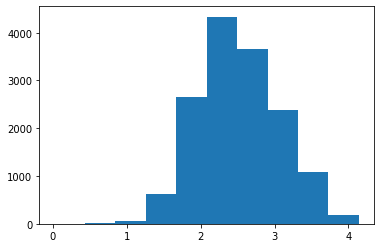

In [55]:
#Distribution of Trained Set
plt.hist(oof_train)

In [56]:
#Compute Quadratic Weighted Kappa based on OOF train predictions: 

optR = OptimizedRounder()
optR.fit(oof_train, X_train['AdoptionSpeed'].values) 
coefficients = optR.coefficients()
pred_test_y_k = optR.predict(oof_train, coefficients)
print("\nValid Counts = ", Counter(X_train['AdoptionSpeed'].values)) 
print("Predicted Counts = ", Counter(pred_test_y_k)) 
print("Coefficients = ", coefficients)
qwk = quadratic_weighted_kappa(X_train['AdoptionSpeed'].values, pred_test_y_k)
print("QWK = ", qwk)


Valid Counts =  Counter({4.0: 4197, 2.0: 4037, 3.0: 3259, 1.0: 3090, 0.0: 410})
Predicted Counts =  Counter({2.0: 4469, 4.0: 3752, 3.0: 3474, 1.0: 3292, 0.0: 6})
Coefficients =  [0.45976316 2.07765722 2.50284342 2.8898671 ]
QWK =  0.45584146703935413


In [57]:
#Manually adjusted coefficients: 

coefficients_ = coefficients.copy()

coefficients_[0]=1.645
coefficients_[1]=2.115
coefficients_[3]=2.84

train_predictions = optR.predict(oof_train, coefficients_).astype(int) 
print('train pred distribution: {}'.format(Counter(train_predictions)))

test_predictions = optR.predict(oof_test.mean(axis=1), coefficients_) 
print('test pred distribution: {}'.format(Counter(test_predictions)))

train pred distribution: Counter({4: 4118, 2: 4094, 3: 3108, 1: 3076, 0: 597})
test pred distribution: Counter({4.0: 1190, 2.0: 1037, 3.0: 840, 1.0: 804, 0.0: 101})


In [58]:
#Distribution inspection of original target and predicted train and test:

print("True Distribution:")
print(pd.value_counts(X_train['AdoptionSpeed'], normalize=True).sort_index())
print("\nTrain Predicted Distribution:")
print(pd.value_counts(train_predictions, normalize=True).sort_index())
print("\nTest Predicted Distribution:")
print(pd.value_counts(test_predictions, normalize=True).sort_index())

True Distribution:
0.0    0.027346
1.0    0.206096
2.0    0.269259
3.0    0.217368
4.0    0.279931
Name: AdoptionSpeed, dtype: float64

Train Predicted Distribution:
0    0.039819
1    0.205162
2    0.273061
3    0.207297
4    0.274662
dtype: float64

Test Predicted Distribution:
0.0    0.025428
1.0    0.202417
2.0    0.261078
3.0    0.211480
4.0    0.299597
dtype: float64


In [59]:
# Generate submission:

submission = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': test_predictions.astype(np.int32)})
submission.head()
submission.to_csv('submissioncat.csv', index=False)